In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import src.utilerias.reader as rd
import src.utilerias.utilerias as utls

# Llamamos a la función antes de ejecutar el script
logs_dir = 'logs/LSTM/estandar'
logs_dir_auto_pred = 'logs/LSTM/auto_predictiva'
utls.eliminar_archivos_registro(logs_dir)
utls.eliminar_archivos_registro(logs_dir_auto_pred)

In [2]:
# DATOS = 'cierre.csv'#Grupo Financiero Inbursa
# DATOS = 'Datos históricos COMI 03012016_27122020.csv' #Datos originales
DATOS = 'datos/Datos históricos COMI 3ene16-31dic2020 semanal.csv' #Datos semanales
# DATOS = 'Datos históricos COMI_prueba 30jun19-31dic2020.csv' #Datos semanales de prueba
# DATOS = 'Datos históricos COMI3ene2016_27dic2020_diario.csv' #Datos originales diarios de prueba
# DATOS = 'Datos históricos COMI_prueba 30jun19-31dic2020_DIARIO.csv' #Datos diarios de prueba

cierre = rd.leer_archivo(DATOS).astype(float)
c_entrenamiento = np.array(cierre[:int(len(cierre) * 0.7)])

#Se convierte en un arreglo bidimensional
c_entrenamiento = np.reshape(c_entrenamiento, (c_entrenamiento.shape[0], 1))

In [3]:
from sklearn.preprocessing import MinMaxScaler

m_m_s = MinMaxScaler(feature_range=(0,1))
c_entrenamiento_n = m_m_s.fit_transform(c_entrenamiento)

In [4]:
#Se crean los conjuntos de entradas y salidas para la red, que funcionaran para predecir y comparar con las salidas esperadas a la hora de realizar el entrenamiento
time_steps = 8
N = len(c_entrenamiento_n) #182
X_entrenamiento_n = []
y_entrenamiento_n = []
for i in range(time_steps, N):
    X_entrenamiento_n.append(c_entrenamiento_n[i-time_steps:i, 0])#toma paquetes de 8 en 8
    y_entrenamiento_n.append(c_entrenamiento_n[i, 0])#se toma el elemento 8+1
X_entrenamiento_n, y_entrenamiento_n = np.array(X_entrenamiento_n), np.array(y_entrenamiento_n)

#Se le da una tercera dimension al conjunto de entradas de entrenamiento
X_entrenamiento_n = np.reshape(X_entrenamiento_n, (X_entrenamiento_n.shape[0], X_entrenamiento_n.shape[1], 1))

In [5]:
from keras.optimizers import Adam
from keras.optimizers import SGD
from keras.losses import mean_squared_error
from keras.models import load_model

#red = load_model('redes/DWT_LSTM/auto_predictiva/LSTM_prueba')

In [6]:
from src.modelos.recurrente.LSTM.LSTM import red_LSTM
from src.modelos.recurrente.GRU.GRU import red_GRU
from src.modelos.auto_regresivo.NARNN_keras.NARNN import NARNN
from keras.callbacks import TensorBoard
import src.modelos.recurrente.entrenamientos.entrenamiento as entr

red = red_LSTM(input_dim = X_entrenamiento_n.shape[1],output_dim= 1)

#red = red_GRU(input_dim = X_entrenamiento_n.shape[1],output_dim= 1)
#red = NARNN(input_dim = X_entrenamiento_n.shape[1],output_dim= 1)
red.compile(optimizer=Adam(learning_rate=0.0001),loss='mean_squared_error')# mejor, , SGD(learning_rate=0.1)
history = red.fit(X_entrenamiento_n,y_entrenamiento_n,epochs=60,batch_size=32,
                  callbacks=[entr.CalendarizadorPesos(logs_dir + f'/red_LSTM'), 
                                   entr.CalendarizadorPredicciones(logs_dir + f'/red_LSTM', X_entrenamiento_n, y_entrenamiento_n),
                                   TensorBoard(log_dir=logs_dir + f'/red_LSTM', histogram_freq=1)])
# Guardar el modelo entrenado
# red.save('models/LSTM.h5')


Epoch 1/60
6/6 [==============================] - 7s 310ms/step - loss: 0.5113
Epoch 2/60
6/6 [==============================] - 0s 93ms/step - loss: 0.4894
Epoch 3/60
6/6 [==============================] - 0s 83ms/step - loss: 0.4686
Epoch 4/60
6/6 [==============================] - 1s 109ms/step - loss: 0.4463
Epoch 5/60
6/6 [==============================] - 1s 99ms/step - loss: 0.4225
Epoch 6/60
6/6 [==============================] - 0s 80ms/step - loss: 0.3943
Epoch 7/60
6/6 [==============================] - 0s 79ms/step - loss: 0.3657
Epoch 8/60
6/6 [==============================] - 0s 83ms/step - loss: 0.3265
Epoch 9/60
6/6 [==============================] - 0s 75ms/step - loss: 0.2872
Epoch 10/60
6/6 [==============================] - 0s 76ms/step - loss: 0.2433
Epoch 11/60
6/6 [==============================] - 0s 76ms/step - loss: 0.1911
Epoch 12/60
6/6 [==============================] - 0s 76ms/step - loss: 0.1372
Epoch 13/60
6/6 [==============================] - 0s 80ms/

In [7]:
precios_reales = cierre[int(len(cierre) * 0.7):] #verdaderos valores del conjunto de prueba
precios_reales = np.reshape(precios_reales, (precios_reales.shape[0], 1)) #se le da una dimension mas

In [8]:
#toma los ultimos 86 elementos, los ultimos 8 de entrenamiento y todos los de prueba  
c_prueba = cierre[len(cierre) - len(precios_reales) - time_steps:]

c_prueba = np.array(c_prueba).reshape(-1,1) #(86,1)

m_m_s_prueba = MinMaxScaler(feature_range=(0,1))
# se normalizan los datos usandlo los parametros que se le dieron a m_m_s
c_prueba_n = m_m_s_prueba.fit_transform(c_prueba)

X_prueba_n = []
for i in range(time_steps, len(c_prueba_n)):
    X_prueba_n.append(c_prueba_n[i-time_steps:i, 0]) # se toman en paquetes de 8 
X_prueba_n = np.array(X_prueba_n)
X_prueba_n = np.reshape(X_prueba_n, (X_prueba_n.shape[0], X_prueba_n.shape[1], 1))#(78, 8, 1)

precios_predichos = red.predict(X_prueba_n)
s_normalizar = precios_predichos

#Se desnormalizan los datos
precios_predichos = m_m_s_prueba.inverse_transform(precios_predichos)

3/3 [==============================] - 0s 4ms/step


# Predicción del conjunto de prueba

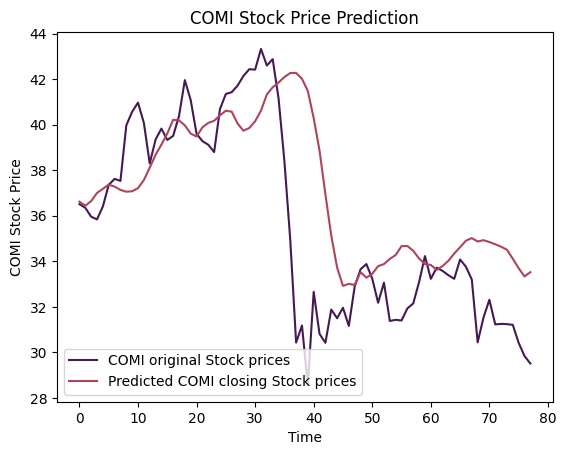

In [20]:
#La normalización funciona correctamente
plt.plot(precios_reales, color = '#451952', label = 'COMI original Stock prices')
plt.plot(precios_predichos, color='#AE445A', label = 'Predicted COMI closing Stock prices')
plt.title('COMI Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('COMI Stock Price')
plt.legend()
plt.show()

# Evaluación de desempeño

In [11]:
import pandas as pd
r_c_prueba_txt = 'Precicción de c_prueba'
# Supongamos que tenemos una lista de errores de predicción para cada red neuronal
rmse = {
    r_c_prueba_txt: utls.rmse(precios_reales,precios_predichos)
}
mape = {
    r_c_prueba_txt: utls.mape(precios_reales,precios_predichos)
}
ds = {
    r_c_prueba_txt: utls.directional_symmetry(precios_reales,precios_predichos)
}

# Creamos un DataFrame de Pandas a partir del diccionario de errores
df_errores = pd.DataFrame({
    'RMSE': pd.Series(rmse),
    'MAPE': pd.Series(mape),
    'DS': pd.Series(ds)
})

# Mostramos el DataFrame con los errores
print(df_errores) 

                         RMSE    MAPE       DS
Precicción de c_prueba  3.463  6.9036  42.3077


In [12]:
# ts_cierre_s_pred = c_entrenamiento_n

# loss_m = []
# for epoch in range(100):  # Número de épocas
#     ts_cierre_s_pred = c_entrenamiento_n[:time_steps]#se obtienen los primeros time_steps(8) elementos del trainig set
#     loss = []
#     X_train_c_pred = []
#     # print(f"grtrt: {ts_cierre_s_pred}")
#     for i in range(time_steps, N):
#         # Obtener las características y la etiqueta actual
#         x_actual = ts_cierre_s_pred[i-time_steps:i,0]
#         X_train_c_pred.append(x_actual)
#         x_actual = x_actual.reshape(1,time_steps,1)

#         y_actual = np.array([y_entrenamiento_n[i-time_steps]])

#         print(f"x_actual: {x_actual}")
#         print(f"y_actual: {y_actual}")
        
#         # Entrenar el modelo con las nuevas características y la etiqueta real
#         #loss.append(red.train_on_batch(x_actual, y_actual))

#         # Predicción del modelo
#         #prediccion = red.predict(x_actual)#.reshape(1,1,1)
#         prediccion = red(x_actual)
        
#         # Agregar la predicción a las características para el siguiente paso
#         # print(ts_cierre_s_pred)
#         print(f"prediccion: {prediccion}")
#         ts_cierre_s_pred = np.concatenate([ts_cierre_s_pred, prediccion])



#     # print(f"mean: {np.mean(np.array(loss))}")
#     # loss_m.append(np.mean(np.array(loss)))
#     X_train_c_pred = np.array(X_train_c_pred)
#     X_train_c_pred = np.reshape(X_train_c_pred, (X_train_c_pred.shape[0], X_train_c_pred.shape[1], 1))
#     history = red.fit(X_train_c_pred, y_entrenamiento_n, epochs=1, batch_size=32)
#     loss = history.history['loss']
#     loss_m.append(loss)
#     loss_m.append(mean_squared_error(c_entrenamiento_n,ts_cierre_s_pred[:,0]))

In [13]:
EPOCAS = 30

import src.modelos.recurrente.entrenamientos.entrenamiento as entrena_lstm
entrena_lstm.entrena(red,c_entrenamiento_n,y_entrenamiento_n,8,epocas= EPOCAS, lr=0.00001, t_lote = 1,
                     callbacks=[entr.CalendarizadorTasaAprendizaje(log_dir=logs_dir_auto_pred+ f'/red_LSTM',initial_lr=0.00001, decay_factor=0,red = red),
                                        entr.CalendarizadorPesos(log_dir=logs_dir_auto_pred+ f'/red_LSTM',e_predictivo=True,genera_histogramas=True,red = red)],
                                        log_dir=logs_dir_auto_pred+ f'/red_LSTM', optimizador=Adam)

#red.save_weights(f'redes/LSTM/auto_predictiva/LSTM.h5')

# red = load_model('redes/DWT_LSTM/auto_predictiva/LSTM_ap_SGD_lr0.01_e10_bs1_df05.h5')

Ejemplar x: [[0.12010849]
 [0.01975978]
 [0.        ]
 [0.01859744]
 [0.05656722]
 [0.02595893]
 [0.03448276]
 [0.04223169]] | y: 0.04610616040294452 | Predicción actual: [[0.23873593]]
Lr que voy a aplicar en el lote es 9.999999747378752e-06
loss en el callback: 0.02459820918738842, batch 1, lote_designado 1
lr: 1e-05, batch: 1
>Fin lote<
Ejemplar x: [[0.01975978]
 [0.        ]
 [0.01859744]
 [0.05656722]
 [0.02595893]
 [0.03448276]
 [0.04223169]
 [0.23873593]] | y: 0.10422316931421921 | Predicción actual: [[0.22217165]]
Lr que voy a aplicar en el lote es 9.999999747378752e-06
loss en el callback: 0.010673691518604755, batch 2, lote_designado 1
lr: 1e-05, batch: 2
>Fin lote<
Ejemplar x: [[0.        ]
 [0.01859744]
 [0.05656722]
 [0.02595893]
 [0.03448276]
 [0.04223169]
 [0.23873593]
 [0.22217165]] | y: 0.15420379697791559 | Predicción actual: [[0.22558668]]
Lr que voy a aplicar en el lote es 9.999999747378752e-06
loss en el callback: 0.0030103924218565226, batch 3, lote_designado 1
lr

[0.13253286698793823,
 0.12460976177771765,
 0.1228836395935044,
 0.1244707914650764,
 0.12076246951500134,
 0.12879377923312593,
 0.12876750184341854,
 0.1261135018451845,
 0.1269932039188677,
 0.12707860155911824,
 0.1282267526231574,
 0.12895599671527452,
 0.12735480648089362,
 0.1288529929167989,
 0.13414995120756082,
 0.13015518841291665,
 0.12746961394893566,
 0.12779266577954337,
 0.1286483457696491,
 0.1286340724697682,
 0.13264467577435593,
 0.13121540176943716,
 0.13358056170971663,
 0.1332945606142031,
 0.13417357514753228,
 0.1354613878439463,
 0.1299295360472739,
 0.13104781209644922,
 0.13261763120976655,
 0.13097367935277926]

1/1 [==============================] - 0s 20ms/step


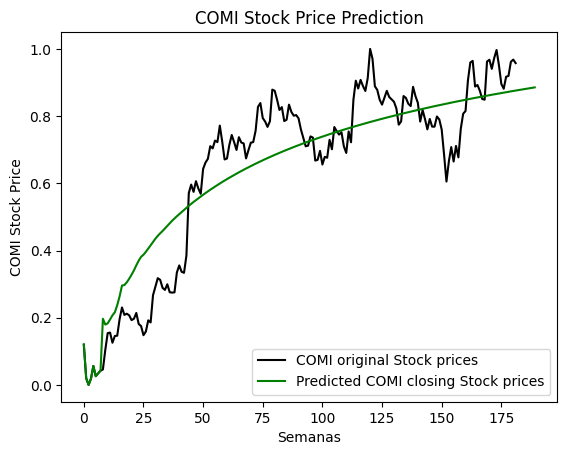

In [14]:
# Predice el conjunto de entrenamiento usando la prediccion predictiva a partir de los primeros (usando los datos que predice)
red_ap_X_entrenamiento_n = c_entrenamiento_n[:time_steps].reshape(8)
red_ap_precios_predichos_n = utls.genera_prediccion_predictiva(red_ap_X_entrenamiento_n,8,182,red)

#Sin normalizar
plt.plot(c_entrenamiento_n, color = 'black', label = 'COMI original Stock prices')
plt.plot(red_ap_precios_predichos_n, color = 'green', label = 'Predicted COMI closing Stock prices') #ts_cierre_s_pred[:,0]
plt.title('COMI Stock Price Prediction')
plt.xlabel('Semanas')
plt.ylabel('COMI Stock Price')
plt.legend()
plt.show()

1/1 [==============================] - 0s 23ms/step


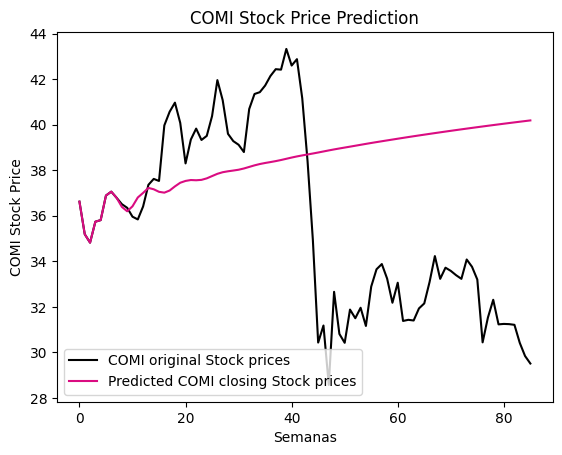

In [22]:
# Ahora, el modelo ha sido entrenado de manera iterativa

red_ap_X_prueba_n = np.reshape(X_prueba_n[0,:], (1, X_prueba_n[0,:].shape[0], 1))
red_ap_precios_predichos = red.predict(red_ap_X_prueba_n)
f_predicted_sp_cierre = m_m_s.inverse_transform(red_ap_precios_predichos)

# Predice el conjunto de prueba usando la prediccion predictiva (ñps datos que va prediciendo)

red_ap_precios_predichos = utls.genera_prediccion_predictiva(red_ap_X_prueba_n.reshape(8),8,78,red)
temp = red_ap_precios_predichos
red_ap_precios_predichos = m_m_s_prueba.inverse_transform(red_ap_precios_predichos.reshape(86,1))

#Sin normalizar
#red_ap_precios_predichos = m_m_s_prueba.inverse_transform(c_prueba_n)
plt.plot(c_prueba, color = 'black', label = 'COMI original Stock prices') #c_prueba_n
plt.plot(red_ap_precios_predichos, color='#DA0C81', label = 'Predicted COMI closing Stock prices')
plt.title('COMI Stock Price Prediction')
plt.xlabel('Semanas')
plt.ylabel('COMI Stock Price')
plt.legend()
plt.show()

In [19]:
import pandas as pd
r_c_prueba_txt = 'Precicción de c_prueba'
# Supongamos que tenemos una lista de errores de predicción para cada red neuronal
rmse = {
    r_c_prueba_txt: utls.rmse(c_prueba,red_ap_precios_predichos)
}
mape = {
    r_c_prueba_txt: utls.mape(c_prueba,red_ap_precios_predichos)
}
ds = {
    r_c_prueba_txt: utls.directional_symmetry(c_prueba,red_ap_precios_predichos)
}

# Creamos un DataFrame de Pandas a partir del diccionario de errores
df_errores = pd.DataFrame({
    'RMSE': pd.Series(rmse),
    'MAPE': pd.Series(mape),
    'DS': pd.Series(ds)
})

# Mostramos el DataFrame con los errores
print(df_errores) 

                          RMSE     MAPE       DS
Precicción de c_prueba  5.5679  13.6945  51.1628
